In [1]:
import anndata
import pandas as pd
import scanpy as sc
from scButterfly.butterfly import Butterfly
print(dir(Butterfly))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'augmentation', 'construct_model', 'data_preprocessing', 'load_data', 'test_model', 'train_model']


In [2]:
butterfly = Butterfly()

In [3]:
from scipy.io import mmread

# Load the matrix, transposition !!!!!!!!!!!!
matrix_6419_A = mmread("./data/Glioblastoma/GSM8820702_6419_A_matrix.mtx").tocsc().transpose()

# Load barcodes and features
barcodes_6419_A = pd.read_csv("./data/Glioblastoma/GSM8820702_6419_A_barcodes.tsv", header=None, sep="\t")
features_6419_A = pd.read_csv("./data/Glioblastoma/GSM8820702_6419_A_features.tsv", header=None, sep="\t", names=['gene_id', 'gene_name', 'gene_type', 'gene_location', 'gene_start', 'gene_end'], index_col=None)

# Create an AnnData object
adata_6419_A = anndata.AnnData(X=matrix_6419_A, obs=pd.DataFrame(index=barcodes_6419_A[0]), var=features_6419_A.set_index('gene_id'))

In [4]:
#Read metadata
metadata = pd.read_csv('./data/Glioblastoma/GSE274986_snrnaseq_metadata.csv', sep=',', index_col=0)
metadata.index = metadata.index.astype(str).str.strip()

#Cleanup metadata
metadata_6419_A = metadata[metadata.index.astype(str).str.startswith('6419_A')]
metadata_6419_A.index = metadata_6419_A.index.astype(str).str.replace('^6419_A_', '', regex=True)

# Reindex metadata to match the AnnData object
# Ensure metadata_6419_A indices match adata.obs indices
metadata_6419_A.index = metadata_6419_A.index.astype(str).str.strip()
metadata_6419_A = metadata_6419_A.reindex(adata_6419_A.obs.index)
metadata_6419_A.index.name = None

# Assign the reindexed metadata to adata.obs
adata_6419_A.obs = metadata_6419_A

In [5]:
# Create ATAC_6419_A: Rows with 'Peaks' in the 'gene_type' column
ATAC_6419_A = adata_6419_A[:, adata_6419_A.var['gene_type'] == 'Peaks'].copy()
ATAC_6419_A = ATAC_6419_A[:, ATAC_6419_A.var['gene_location'].str.startswith('chr')].copy()

# Create RNA_6419_A: Rows with 'Gene Expression' in the 'gene_type' column
RNA_6419_A = adata_6419_A[:, adata_6419_A.var['gene_type'] == 'Gene Expression'].copy()

In [6]:
# Verify ATAC_6419_A
print(ATAC_6419_A.shape)  # Should show the number of rows with 'Peaks'
print(ATAC_6419_A.var['gene_type'].unique())  # Should only contain 'Peaks'

# Verify RNA_6419_A
print(RNA_6419_A.shape)  # Should show the number of rows with 'Gene Expression'
print(RNA_6419_A.var['gene_type'].unique())  # Should only contain 'Gene Expression'

(10405, 164987)
['Peaks']
(10405, 36601)
['Gene Expression']


In [7]:
from scButterfly.split_datasets import *
id_list = five_fold_split_dataset(RNA_data=RNA_6419_A, ATAC_data=ATAC_6419_A)
train_id, validation_id, test_id = id_list[4]

In [8]:
butterfly.load_data(RNA_data=RNA_6419_A, ATAC_data=ATAC_6419_A, train_id=train_id, test_id=test_id, validation_id=validation_id)

[INFO] Butterfly: successfully load in data with

RNA data:
AnnData object with n_obs × n_vars = 10405 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'Region', 'Pct_mito', 'Sample', 'Batch', 'Patient', 'CellClass_L1', 'CellClass_L2', 'CellClass_L3', 'Platform', 'CCI_CellClass_L1', 'CCI_CellClass_L2', 'Confident_Annotation', 'is_malignant_confident', 'scVI_snn_res.0.5'
    var: 'gene_name', 'gene_type', 'gene_location', 'gene_start', 'gene_end'

ATAC data:
AnnData object with n_obs × n_vars = 10405 × 164987
    obs: 'nCount_RNA', 'nFeature_RNA', 'Region', 'Pct_mito', 'Sample', 'Batch', 'Patient', 'CellClass_L1', 'CellClass_L2', 'CellClass_L3', 'Platform', 'CCI_CellClass_L1', 'CCI_CellClass_L2', 'Confident_Annotation', 'is_malignant_confident', 'scVI_snn_res.0.5'
    var: 'gene_name', 'gene_type', 'gene_location', 'gene_start', 'gene_end'


In [9]:
butterfly.data_preprocessing()

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] ATAC preprocessing: binarizing data.
[INFO] ATAC preprocessing: filter out peaks appear lower than 0.5% cells.
[INFO] ATAC preprocessing: TF-IDF transformation.
[INFO] ATAC preprocessing: normalizing data.


In [10]:
butterfly.ATAC_data_p.var.gene_location

gene_id
chr1:9803-10696           chr1
chr1:181048-181703        chr1
chr1:183866-184782        chr1
chr1:191028-191940        chr1
chr1:629495-630387        chr1
                          ... 
chrY:11332855-11333560    chrY
chrY:11333683-11334336    chrY
chrY:56836395-56837250    chrY
chrY:56850397-56851298    chrY
chrY:56870710-56871476    chrY
Name: gene_location, Length: 163292, dtype: object

In [13]:
chrom_list = []
last_one = ''
for i in range(len(butterfly.ATAC_data_p.var.gene_location)):
    temp = butterfly.ATAC_data_p.var.gene_location[i]
    if temp[0 : 3] == 'chr':        #if the chromosome name starts with 'chr'
        if not temp == last_one:    #if chrom name =/= last chrom name
            chrom_list.append(1)    #add new element to chrom_list
            last_one = temp         #update last chrom name to compare with next
        else:                       #if chrom name stays the same
            chrom_list[-1] += 1     #add another peak to last chrom in chrom_list
    else:                           #if the chromosome name does not start with 'chr'
        chrom_list[-1] += 1         #add another peak to last chrom in chrom_list

print(chrom_list, end="")           #no. peaks per chromosome
print(sum(chrom_list))

[14728, 7905, 8825, 8067, 4682, 5283, 5177, 5481, 6554, 3983, 4780, 13517, 4504, 1836, 3129, 10811, 7750, 9731, 9189, 8654, 8039, 6842, 3811, 14]163292


In [14]:
butterfly.augmentation(aug_type=None)

In [15]:
butterfly.construct_model(chrom_list)

[INFO] Butterfly: successfully construct butterfly model.


In [21]:
butterfly.train_model() #(output_path='./data/Glioblastoma/scbutterfly_model_6419_A', logging_path='./data/Glioblastoma/scbutterfly_model_6419_A/logs')

[INFO] Butterfly: training butterfly model ...
[INFO] Trainer: RNA pretraining ...
[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [34:23<00:00, 20.63s/it, train=0.0523, val=0.0526]
[INFO] Trainer: ATAC pretraining ...
[INFO] Trainer: ATAC pretraining ...
ATAC pretrain: 100%|████████████████████| 100/100 [35:07<00:00, 21.08s/it, train=0.0048, val=0.0048]
[INFO] Trainer: Integrative training ...
[INFO] Trainer: Integrative training ...
Integrative training:   0%|                                                 | 0/200 [00:03<?, ?it/s]


ValueError: too many values to unpack (expected 6)

In [22]:
print("loss_weight:", loss_weight)
print("Length of loss_weight:", len(loss_weight))

NameError: name 'loss_weight' is not defined

In [ ]:
A2R_predict, R2A_predict = butterfly.test_model()

[INFO] Butterfly: testing butterfly model ...
[INFO] Butterfly: testing butterfly model ...
[INFO] Butterfly: testing butterfly model ...
[INFO] Butterfly: testing butterfly model ...
[INFO] Tester: get predicting ...
ATAC to RNA predicting...: 100%|██████████████████████████████████████| 2/2 [00:02<00:00,  1.23s/it]
[INFO] Tester: calculate neighbors graph for following test ...


In [ ]:
from scButterfly.calculate_cluster import calculate_cluster_index

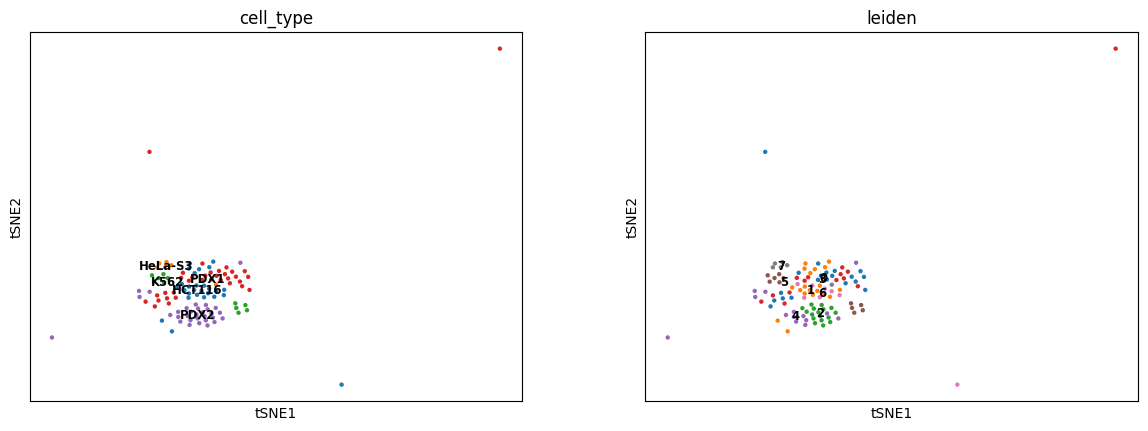

In [ ]:
sc.tl.tsne(A2R_predict)
sc.tl.leiden(A2R_predict)
sc.pl.tsne(A2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small', size=40)

In [ ]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2A_predict)
print('RNA to ATAC:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to ATAC:
ARI: 0.949, 	AMI: 0.951, 	NMI: 0.954, 	HOM: 0.954


In [ ]:
ARI, AMI, NMI, HOM = calculate_cluster_index(A2R_predict)
print('ATAC to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

ATAC to RNA:
ARI: 0.636, 	AMI: 0.825, 	NMI: 0.839, 	HOM: 1.000
